DO NOT RUN WITHOUT CHECKING! It will overwrite named files!



Copied from "2025-05-15 Full tracking optimization of steering for real BBA offsets - new optimizer.ipynb"

Added little chunks of code to dump the misalignment and steering solutions

In [1]:
import json

misalignmentConfig = []
steeringConfig = []

## Setup

In [2]:
from UTILITY_quickstart import *  
from tabulate import tabulate


importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.yml")  

#New DL10 centering 
importedDefaultSettings = importedDefaultSettings | {"centerDL10" : True}

#Disable BC14 centering
importedDefaultSettings = importedDefaultSettings | { "centerBC14" : False }

In [3]:
csrTF           = True #This config is intended for use with CSR on... but for speed, start with it off
transverseWakes = True #Initially disabling for faster computation

evalElement = "Q19501"   
inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"] 
bunchCount = importedDefaultSettings["bunchCount"] 

tao = initializeTao(     
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,          
    csrTF = csrTF,     
    numMacroParticles=1e4,     
    scratchPath = "/tmp",     
    randomizeFileNames = True,      
    transverseWakes = transverseWakes 
)


totalNumElements = len(tao.lat_list("*", "ele.name"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Transverse wakes enabled!
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_8908776830336422144.h5, and reinit to tao


In [4]:
# For simplicity, disable all apertures. Very nonphysical, but the single particle tracking failure is causing problems

for eleII in range(totalNumElements):
    try:
        tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
    except:
        pass

In [5]:
trackBeam(tao, 
          trackEnd = "L0BFEND", 
          verbose = True
         ) 
PInit = getBeamAtElement(tao, "L0AFEND")

artificialFactor = 1.3 
#artificialFactor = 1.0 
PInit.x = artificialFactor * PInit.x 
PInit.px = artificialFactor * PInit.px 
PInit.y = artificialFactor * PInit.y 
PInit.py = artificialFactor * PInit.py  

makeBeamActiveBeamFile(PInit, tao = tao)

Loaded /tmp/beams/activeBeamFile_8908776830336422144.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [6]:
# tao.lat_list("Q*", "ele.name", flags="-no_slaves") 
# Manually pared list of only "normal" quads in L1, L2, and L3
linacQuads = [
    'QM10771', 'QM10781', 'QA11132', 'Q11201', 'QA11265', 'Q11301', 
    'QM11393', 'Q11401', 'Q11501', 'Q11601', 'Q11701', 'Q11801', 'Q11901', 'Q12201', 'Q12301', 'Q12401', 'Q12501', 'Q12601', 'Q12701', 'Q12801', 'Q12901', 'Q13201', 'Q13301', 'Q13401', 'Q13501', 'Q13601', 'Q13701', 'Q13801', 'Q13901', 'Q14201', 'Q14301', 'Q14401', 'Q14501', 'Q14601', 'Q14701', 'QM14715',
    'QM14891', 'Q14901', 'Q15201', 'Q15301', 'Q15401', 'Q15501', 'Q15601', 'Q15701', 'Q15801', 'Q15901', 'Q16201', 'Q16301', 'Q16401', 'Q16501', 'Q16601', 'Q16701', 'Q16801', 'Q16901', 'Q17201', 'Q17301', 'Q17401', 'Q17501', 'Q17601', 'Q17701', 'Q17801', 'Q17901', 'Q18201', 'Q18301', 'Q18401', 'Q18501', 'Q18601', 'Q18701', 'Q18801', 'Q18901', 'Q19201', 'Q19301', 'Q19401', 'Q19501', 'Q19601', 'Q19701', 'Q19801', 'Q19851', 'Q19871'
]

#quadsToPerturb = linacQuads

#To accommodate 2014 BBA data, pick subset from z = 1100 to 1800
quadsToPerturb = [
    'Q11801', 'Q11901', 'Q12201', 'Q12301', 'Q12401', 'Q12501', 'Q12601', 'Q12701', 'Q12801', 'Q12901', 'Q13201', 'Q13301', 'Q13401', 'Q13501', 'Q13601', 'Q13701', 'Q13801', 'Q13901', 'Q14201', 'Q14301', 'Q14401', 'Q14501', 'Q14601', 'Q14701', 'QM14715',
    'QM14891', 'Q14901', 'Q15201', 'Q15301', 'Q15401', 'Q15501', 'Q15601', 'Q15701', 'Q15801', 'Q15901', 'Q16201', 'Q16301', 'Q16401', 'Q16501', 'Q16601', 'Q16701', 'Q16801', 'Q16901', 'Q17201', 'Q17301', 'Q17401', 'Q17501', 'Q17601', 'Q17701', 'Q17801', 'Q17901', 'Q18201', 'Q18301', 'Q18401', 'Q18501', 'Q18601', 'Q18701', 'Q18801', 'Q18901', 'Q19201', 'Q19301', 'Q19401', 'Q19501', #'Q19601', 'Q19701'
]

In [7]:
print(tao.ele_head("Q11801"))
print(tao.ele_head("Q19501"))

{'universe': 1, '1^ix_branch': 0, 'ix_ele': 1655, 'key': 'Quadrupole', 'name': 'Q11801', 'type': '1.085Q4.31', 'alias': 'LI11:QUAD:801', 'descrip': '', 'is_on': True, 's': 103.262182575811, 's_start': 103.155382575811, 'ref_time': 3.4446255706666e-07, 'has#methods': True, 'has#ab_multipoles': True, 'has#kt_multipoles': False, 'has#multipoles_elec': True, 'has#ac_kick': False, 'has#taylor': False, 'has#spin_taylor': False, 'has#wake': False, 'num#cartesian_map': 0, 'num#cylindrical_map': 0, 'num#gen_grad_map': 0, 'num#grid_field': 0, 'has#wall3d': 0, 'has#control': False, 'has#twiss': True, 'has#mat6': True, 'has#floor': True, 'has#photon': False, 'has#lord_slave': True}
{'universe': 1, '1^ix_branch': 0, 'ix_ele': 1233, 'key': 'Quadrupole', 'name': 'Q19501', 'type': '1.085Q4.31', 'alias': 'LI19:QUAD:501', 'descrip': '', 'is_on': True, 's': 879.046969853447, 's_start': 878.940169853447, 'ref_time': 2.93220210127131e-06, 'has#methods': True, 'has#ab_multipoles': True, 'has#kt_multipoles':

## Baseline

In [8]:
setLattice(tao, **importedDefaultSettings)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_8908776830336422144.h5
Set track_start = L0AFEND, track_end = Q19501
Set track_end = ENDDL10
Tracking!
Beam centered at ENDDL10 written to /tmp/beams/patchBeamFile_8908776830336422144.h5
Loaded /tmp/beams/patchBeamFile_8908776830336422144.h5
Set track_start = ENDDL10, track_end = Q19501
Tracking!
trackBeam() exiting


In [9]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)", printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

+-------------------+---------------+---------------+
| 90% RMS           |               |               |
| emittance (not    |        X      |        Y      |
| SI90!) [um-rad]   |               |               |
+===================+===============+===============+
| PR10571           |          3.89 |          2.91 |
+-------------------+---------------+---------------+
| WS12214           |          4.45 |          2.78 |
+-------------------+---------------+---------------+
| BEGBC14           |          5.2  |          2.75 |
+-------------------+---------------+---------------+
| ENDBC14           |          6.1  |          2.76 |
+-------------------+---------------+---------------+
| Q19501            |          6.48 |          3.78 |
| (L3 wire proxy)   |               |               |
+-------------------+---------------+---------------+


## Steering optimizer functions

In [10]:
from scipy.optimize import minimize



combinedElementData = [
    {
        "eleII" : eleII,
        "name" : tao.ele_head(eleII)["name"],
        "key" : tao.ele_head(eleII)["key"],
        "s" : tao.ele_head(eleII)["s"]
    }
    for eleII in range(totalNumElements) 
]

#Keep only elements after L0AFEND
combinedElementData = [ele for ele in combinedElementData if ele["s"] > 4.1274477]

allHKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "HKicker"]
allVKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "VKicker"]

#Manually picking a list of elements that seem like BPMs. Fast and dirty, DNT
#[ele["name"] for ele in combinedElementData if ele["key"] == "Monitor"]
#allBPMNames = ['BPM10371', 'BPM10425', 'BPM10511', 'BPM10525',  'BPM10581', 'BPM10631', 'BPM10651', 'BPM10731', 'BPM10771', 'BPM10781', 'BPM11132', 'BPM11201', 'BPM11265', 'BPM11301', 'BPM11312', 'BPM11333', 'BPM11358', 'BPM11362', 'BPM11393', 'BPM11401', 'BPM11501', 'BPM11601', 'BPM11701', 'BPM11801', 'BPM11901', 'BPM12201', 'BPM12301', 'BPM12401', 'BPM12501', 'BPM12601', 'BPM12701', 'BPM12801', 'BPM12901', 'BPM13201', 'BPM13301', 'BPM13401', 'BPM13501', 'BPM13601', 'BPM13701', 'BPM13801', 'BPM13901', 'BPM14201', 'BPM14301', 'BPM14401', 'BPM14501', 'BPM14601', 'BPM14701', 'BPM14715', 'BPM14801', 'BPM14891', 'BPM14901', 'BPM15201', 'BPM15301', 'BPM15401', 'BPM15501', 'BPM15601', 'BPM15701', 'BPM15801', 'BPM15901', 'BPM16201', 'BPM16301', 'BPM16401', 'BPM16501', 'BPM16601', 'BPM16701', 'BPM16801', 'BPM16901', 'BPM17201', 'BPM17301', 'BPM17401', 'BPM17501', 'BPM17601', 'BPM17701', 'BPM17801', 'BPM17901', 'BPM18201', 'BPM18301', 'BPM18401', 'BPM18501', 'BPM18601', 'BPM18701', 'BPM18801', 'BPM18901', 'BL18900', 'BPM19201', 'BPM19301', 'BPM19401', 'BPM19801', 'BPM19851', 'BPM19871', 'M1E', 'M3E', 'MS2EL', 'M4E', 'M5E', 'M6E', 'M7E', 'M8E', 'MS2ER', 'M9E', 'M11E', 'M1FF', 'M2FF', 'M3FF', 'M4FF', 'M5FF', 'M0EX', 'M1EX', 'M2EX', 'M3EX']

#For this notebook only, steer to centers of quads instead of BPMs
#BEWARE!!! Horrible misnomer!!!
allBPMNames = quadsToPerturb




######################################
#Optional: Limit kickers and BPMs by s
######################################

optimizerBPMSMin =  100  #100
optimizerBPMSMax =  880  #905
optimizerKickerSMin = optimizerBPMSMin - 20 #Go a bit upstream from first BPM considered
optimizerKickerSMax = optimizerBPMSMax


allBPMNames     = [ ele for ele in allBPMNames     if optimizerBPMSMin    < tao.ele_head(ele)["s"] < optimizerBPMSMax   ]
allHKickerNames = [ ele for ele in allHKickerNames if optimizerKickerSMin < tao.ele_head(ele)["s"] < optimizerKickerSMax]
allVKickerNames = [ ele for ele in allVKickerNames if optimizerKickerSMin < tao.ele_head(ele)["s"] < optimizerKickerSMax]

#Make sure tracked beam is available at all BPMs
#Doing this in a loop because Bmad sometimes gets weird about long lists...
for ele in allBPMNames:
    tao.cmd(f"set beam add_saved_at = {ele}")

In [11]:
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

def getActualXOffset(tao, ele):
    return tao.ele_orbit(ele)["x"] - (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0])

def getActualYOffset(tao, ele):
    return tao.ele_orbit(ele)["y"] - (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1])


def makeXPerturbationMatrix(delta, trackEnd = "end"):

    referenceRow = np.array( [ getActualXOffset( tao, ele ) for ele in allBPMNames ] )

    #print(referenceRow) 
    
    perturbationMatrix = []
    
    for kicker in allHKickerNames:

        #Tweak the kicker
        setKickerkG( tao, kicker, delta + getKickerkG( tao, kicker ) )

        trackBeam(tao, 
          trackEnd = trackEnd,
          **importedDefaultSettings
         )

        perturbationRow = np.array( [ getActualXOffset( tao, ele ) for ele in allBPMNames ] ) - referenceRow

        perturbationMatrix.append(perturbationRow) 

        #Put it back where it started
        setKickerkG( tao, kicker, -1 * delta + getKickerkG( tao, kicker ) )

    #Normalize
    perturbationMatrix = np.array(perturbationMatrix) / delta
    
    return perturbationMatrix

def makeYPerturbationMatrix(delta, trackEnd = "end"):

    referenceRow = np.array( [ getActualYOffset( tao, ele ) for ele in allBPMNames ] )

    #print(referenceRow) 
    
    perturbationMatrix = []
    
    for kicker in allVKickerNames:

        #Tweak the kicker
        setKickerkG( tao, kicker, delta + getKickerkG( tao, kicker ) )

        trackBeam(tao, 
          trackEnd = trackEnd,
          **importedDefaultSettings
         )

        perturbationRow = np.array( [ getActualYOffset( tao, ele ) for ele in allBPMNames ] ) - referenceRow

        perturbationMatrix.append(perturbationRow) 

        #Put it back where it started
        setKickerkG( tao, kicker, -1 * delta + getKickerkG( tao, kicker ) )

    #Normalize
    perturbationMatrix = np.array(perturbationMatrix) / delta
    
    return perturbationMatrix


def solveForKickerCorrectionsBounded(perturbationMatrix, referenceRow, bound=0.1):
    P = np.array(perturbationMatrix).T  # [numBPMs x numKickers]
    r = np.array(referenceRow)

    # Solve P @ k = -r using least squares in case it's over/under-constrained
    result = lsq_linear(P, -r, bounds=(-bound, bound))

    if not result.success:
        print("Warning: Solver did not converge.")
    
    return result.x

## Introduce BBA error (2014 Blue/Pink or Winter 2025)

In [12]:
import json

# quadZValues = { ele : tao.ele_floor(ele)["Actual"][2] for ele in quadsToPerturb }

# with open("./quadZValues.json", "w") as f:
#     json.dump(quadZValues, f, indent=2)

#Generated with "2025-05-12 Processing real BBA data from 2014.nb"
#These are in [mm]!
with open('pinkCurveXOffsets.json', 'r') as file:
    pinkCurveXOffsets = json.load(file)

with open('pinkCurveYOffsets.json', 'r') as file:
    pinkCurveYOffsets = json.load(file)

with open('blueCurveXOffsets.json', 'r') as file:
    blueCurveXOffsets = json.load(file)

with open('blueCurveYOffsets.json', 'r') as file:
    blueCurveYOffsets = json.load(file)

In [13]:
# Winter 2025 offsets
# Originally from https://docs.google.com/spreadsheets/d/1VESuoMSxWwHJK1JQyTcc8gQS6xGaTuhHrGknu5jDbnc/edit?gid=1142612034#gid=1142612034
# Parsed in 2025-05-15 Parsing winter 2025 BBA data.xlsx

winter2025XOffsets = { 'QM10771': 0,
 'QM10781': 0,
 'QA11132': 0,
 'Q11201'	: 0,
 'QA11265': 0,
 'Q11301'	: 0,
 'QM11393': 0.09,
 'Q11401'	: 0.44,
 'Q11501'	: -0.19,
 'Q11601'	: -0.25,
 'Q11701'	: 0,
 'Q11801'	: 0.17,
 'Q11901'	: -0.16,
 'Q12201'	: 0,
 'Q12301'	: -0.06,
 'Q12401'	: 0.01,
 'Q12501'	: 0,
 'Q12601'	: -0.2,
 'Q12701'	: 0.1,
 'Q12801'	: 0.11,
 'Q12901'	: 0.03,
 'Q13201'	: 0.02,
 'Q13301'	: -0.03,
 'Q13401'	: -0.3,
 'Q13501'	: -0.01,
 'Q13601'	: 0.07,
 'Q13701'	: -0.11,
 'Q13801'	: 0.15,
 'Q13901'	: -0.03,
 'Q14201'	: 0.1,
 'Q14301'	: -0.16,
 'Q14401'	: 0,
 'Q14501'	: -0.11,
 'Q14601'	: 0.1,
 'Q14701'	: 0,
 'QM14715': 0,
 'QM14891': 0,
 'Q14901'	: 0,
 'Q15201'	: 0,
 'Q15301'	: -0.15,
 'Q15401'	: 0.26,
 'Q15501'	: 0,
 'Q15601'	: -0.15,
 'Q15701'	: 0.41,
 'Q15801'	: -0.03,
 'Q15901'	: 0.01,
 'Q16201'	: 0.03,
 'Q16301'	: -0.07,
 'Q16401'	: 0.05,
 'Q16501'	: 0,
 'Q16601'	: -0.06,
 'Q16701'	: 0.08,
 'Q16801'	: -0.05,
 'Q16901'	: 0.02,
 'Q17201'	: -0.05,
 'Q17301'	: -0.03,
 'Q17401'	: -0.06,
 'Q17501'	: -0.26,
 'Q17601'	: 0.13,
 'Q17701'	: -0.05,
 'Q17801'	: 0.24,
 'Q17901'	: 0.4,
 'Q18201'	: 0.05,
 'Q18301'	: 0.25,
 'Q18401'	: -0.04,
 'Q18501'	: 0.33,
 'Q18601'	: -0.05,
 'Q18701'	: -0.14,
 'Q18801'	: 0.05,
 'Q18901'	: 0.01,
 'Q19201'	: 0.09,
 'Q19301'	: -0.06,
 'Q19401'	: 0,
 'Q19501'	: 0.14,
 'Q19601'	: -0.06,
 'Q19701'	: 0.2,
 'Q19801'	: 0,
 'Q19851'	: 0.7,
 'Q19871'	: 1.5,
}

winter2025YOffsets = {
  'QM10771' : 0,
 'QM10781' : 0,
 'QA11132' : 0,
 'Q11201' : 0,
 'QA11265' : 0,
 'Q11301' : 0,
 'QM11393' : -0.25,
 'Q11401' : -0.37,
 'Q11501' : -0.06,
 'Q11601' : 0.02,
 'Q11701' : 0,
 'Q11801' : -0.09,
 'Q11901' : 0.23,
 'Q12201' : 0.12,
 'Q12301' : 0.09,
 'Q12401' : 0.11,
 'Q12501' : 0,
 'Q12601' : -0.3,
 'Q12701' : -0.32,
 'Q12801' : 0.04,
 'Q12901' : -0.02,
 'Q13201' : -0.02,
 'Q13301' : 0.05,
 'Q13401' : -0.38,
 'Q13501' : -0.06,
 'Q13601' : 0.09,
 'Q13701' : 0.06,
 'Q13801' : 0.01,
 'Q13901' : -0.01,
 'Q14201' : 0.09,
 'Q14301' : 0.09,
 'Q14401' : -0.04,
 'Q14501' : -0.03,
 'Q14601' : 0.08,
 'Q14701' : -0.08,
 'QM14715' : 0,
 'QM14891' : 0,
 'Q14901' : 0,
 'Q15201' : -0.02,
 'Q15301' : 0.16,
 'Q15401' : 0.01,
 'Q15501' : -0.02,
 'Q15601' : -0.36,
 'Q15701' : 0.01,
 'Q15801' : 0.05,
 'Q15901' : -0.14,
 'Q16201' : 0.04,
 'Q16301' : 0.05,
 'Q16401' : -0.06,
 'Q16501' : -0.05,
 'Q16601' : 0.07,
 'Q16701' : 0.36,
 'Q16801' : 0,
 'Q16901' : 0.05,
 'Q17201' : -0.06,
 'Q17301' : -0.01,
 'Q17401' : -0.43,
 'Q17501' : 0.07,
 'Q17601' : -0.8,
 'Q17701' : -0.09,
 'Q17801' : 0.23,
 'Q17901' : -0.02,
 'Q18201' : 0.45,
 'Q18301' : 0.12,
 'Q18401' : 0.5,
 'Q18501' : 0.1,
 'Q18601' : 0,
 'Q18701' : -0.04,
 'Q18801' : -0.02,
 'Q18901' : -0.02,
 'Q19201' : 0.05,
 'Q19301' : -0.2,
 'Q19401' : 0,
 'Q19501' : -0.11,
 'Q19601' : 0,
 'Q19701' : 0.05,
 'Q19801' : 0,
 'Q19851' : -0.1,
 'Q19871' : 0.15,
}

In [14]:
# quadsToPerturbSValues = [ tao.ele_head(ele)["s"] for ele in quadsToPerturb ] 

In [15]:
# quadPerturbValues = [ 1e-3 * pinkCurveXOffsets[ele] for ele in quadsToPerturb]



# fig, ax = plt.subplots()
# ax.scatter(quadsToPerturbSValues, 1e3 * np.array(quadPerturbValues) )

# for i, txt in enumerate(quadsToPerturb):
#     if i % 5 == 0:
#         ax.annotate(txt, (quadsToPerturbSValues[i], (1e3 * np.array(quadPerturbValues))[i]))

# ax.set_xlabel("s [m]")
# ax.set_ylabel("x error [mm]")

# plt.show()









# quadPerturbValues = [ 1e-3 * pinkCurveYOffsets[ele] for ele in quadsToPerturb]

# fig, ax = plt.subplots()
# ax.scatter(quadsToPerturbSValues, 1e3 * np.array(quadPerturbValues) )

# for i, txt in enumerate(quadsToPerturb):
#     if i % 5 == 0:
#         ax.annotate(txt, (quadsToPerturbSValues[i], (1e3 * np.array(quadPerturbValues))[i]))

# ax.set_xlabel("s [m]")
# ax.set_ylabel("y error [mm]")

# plt.show()

In [16]:
#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = F")

for ele in quadsToPerturb:
    #moveBy = 1e-3 * pinkCurveXOffsets[ele]
    moveBy = 1e-3 * blueCurveXOffsets[ele]
    #moveBy = 1e-3 * winter2025XOffsets[ele]
    tao.cmd(f"set ele {ele} X_OFFSET = {moveBy}")


    misalignmentConfig.append( [ ele, "X_OFFSET", moveBy ] ) 
    

for ele in quadsToPerturb:
    #moveBy = 1e-3 * pinkCurveYOffsets[ele]
    moveBy = 1e-3 * blueCurveYOffsets[ele]
    #moveBy = 1e-3 * winter2025YOffsets[ele]
    tao.cmd(f"set ele {ele} Y_OFFSET = {moveBy}")


    misalignmentConfig.append( [ ele, "Y_OFFSET", moveBy ] ) 

#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = T")

[]

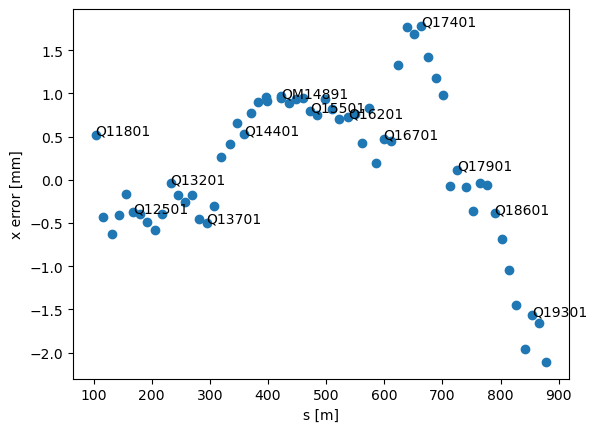

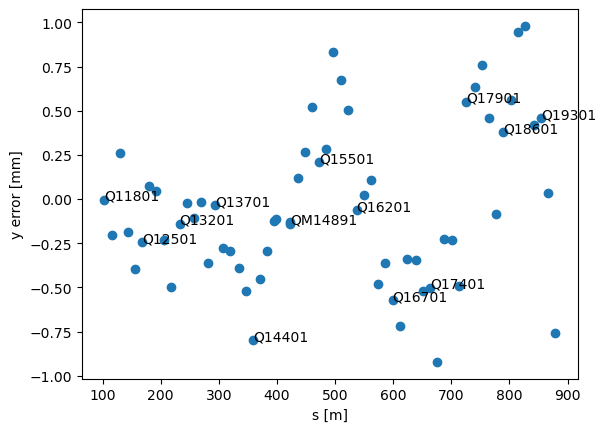

In [17]:
fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in quadsToPerturb ],
    [ 1e3 * (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0]) for ele in quadsToPerturb]
)

for i, txt in enumerate(quadsToPerturb):
    if i % 5 == 0:
        ax.annotate(txt, ([ tao.ele_head(ele)["s"] for ele in quadsToPerturb ][i], [ 1e3 * (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0]) for ele in quadsToPerturb][i]))

ax.set_xlabel("s [m]")
ax.set_ylabel("x error [mm]")

plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in quadsToPerturb ],
    [ 1e3 * (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1]) for ele in quadsToPerturb]
)

for i, txt in enumerate(quadsToPerturb):
    if i % 5 == 0:
        ax.annotate(txt, ([ tao.ele_head(ele)["s"] for ele in quadsToPerturb ][i], [ 1e3 * (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1]) for ele in quadsToPerturb][i]))

ax.set_xlabel("s [m]")
ax.set_ylabel("y error [mm]")

plt.show()

In [18]:
setLattice(tao, **importedDefaultSettings)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_8908776830336422144.h5
Set track_start = L0AFEND, track_end = Q19501
Set track_end = ENDDL10
Tracking!
Beam centered at ENDDL10 written to /tmp/beams/patchBeamFile_8908776830336422144.h5
Loaded /tmp/beams/patchBeamFile_8908776830336422144.h5
Set track_start = ENDDL10, track_end = Q19501
Tracking!
trackBeam() exiting


In [19]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6
    activeData[f"{activeEle}_charge"] = getBeamAtElement(tao, activeEle).charge * 1e9

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

In [20]:
# print(tabulate([
#     ["PR10571",                  printableData["PR10571_x"],    printableData["PR10571_y"]  , printableData["PR10571_charge"]   ], 
#     ["WS12214",                  printableData["WS12214_x"],    printableData["WS12214_y"]  , printableData["WS12214_charge"]   ],
#     ["BEGBC14",                  printableData["BEGBC14_1_x"],  printableData["BEGBC14_1_y"], printableData["BEGBC14_1_charge"] ],
#     ["ENDBC14",                  printableData["ENDBC14_2_x"],  printableData["ENDBC14_2_y"], printableData["ENDBC14_2_charge"] ],
#     ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"],    printableData["Q19501_y"]  , printableData["Q19501_charge"]   ]
# ], 
# ["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     ", "\n  Charge  "], 
# tablefmt="grid"))

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

+-------------------+---------------+---------------+
| 90% RMS           |               |               |
| emittance (not    |        X      |        Y      |
| SI90!) [um-rad]   |               |               |
+===================+===============+===============+
| PR10571           |          3.89 |          2.91 |
+-------------------+---------------+---------------+
| WS12214           |          7.23 |          4.24 |
+-------------------+---------------+---------------+
| BEGBC14           |         11.73 |          6.57 |
+-------------------+---------------+---------------+
| ENDBC14           |         14.16 |          6.84 |
+-------------------+---------------+---------------+
| Q19501            |         21.59 |          7.22 |
| (L3 wire proxy)   |               |               |
+-------------------+---------------+---------------+


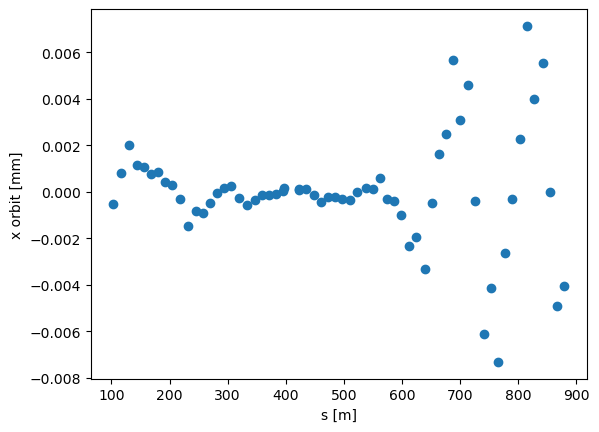

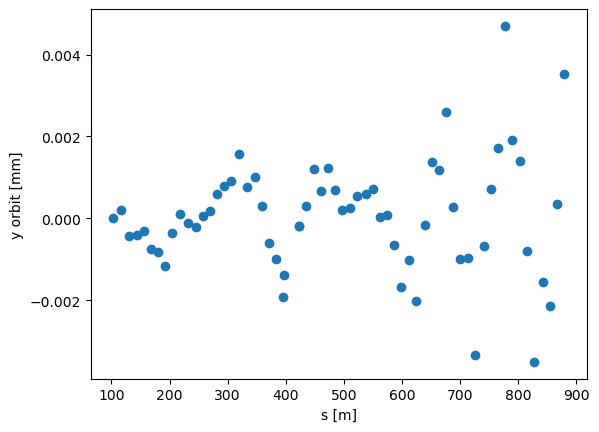

In [21]:
fig, ax = plt.subplots()

ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualXOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("x orbit [mm]")
plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualYOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("y orbit [mm]")
plt.show()

## Steered

### Optionally preload kickers

In [22]:
# xKickerValues = [-0.0012299156922367899, 0.0036909198251430498, -0.00204853413134078, -0.00113618734636576, -0.00010707036734953999, 0.0018503840040792199, -0.000902582069530623, 0.000486558828588583, -9.30377049596747e-06, -0.00162764257001566, -0.0007864095900374909, 0.00288353992098441, -0.000372964681946411, -0.00132200186597416, 0.00303757740882419, -0.00206124656304639, -0.00203862436429762, -0.00400715025057273, 0.00463196263285361, -0.0013967433117998901, 0.0039611767933695, -0.004377137697973221, 0.0015122432815238701, 0.00129789485523317, -0.00164943680604406, -0.000180445674956334, -0.00144831518313112, 0.000560751730429244, 0.00216100575736701, -0.00149335566268395, -0.00337655860107747, 0.004685008365390941, -9.5089232505786e-05, -0.00210030853225945, -0.000245241342153187, 0.0060717646583403895, -0.012570063821848, 0.0181249332942992, -0.016497503410775098, 0.005811504564040251, -0.0173642202286929, 0.0101380556777665, 0.008293739047139311, -0.0035113480141178996, 0.00928143598070091, -0.0026814844568181498, -0.000684951690275022, 0.0184959637008592, -0.0281149477295563, 0.00921078680620006, 0.00232169067531163, -0.0135955349911843, 0.00850974595607686, 0.00693078628740278, -0.000958681921002528, 0.00197396799761499, 0.00057913668167686, 0.00115044700442295, -0.021063474181237298, 0.013218090790981398, 0.009053202870915919, -0.0155628348635141, -0.00791267513408398, -0.000576324301864178]
# yKickerValues = [5.2038121974675505e-06, 0.000570666872175789, -0.00188332248923009, 0.0029910220178399997, -0.0009395099805594, -0.00147092375718302, -0.0008142579775059451, 0.0018002996166825301, 0.0013525567175661, 0.000170077193888489, -0.0036988479946142103, 0.00115276259447897, 0.0014732704685902899, -0.00150675560112717, 0.00374856038729915, -0.00602678539043203, 0.0055114825149359704, -0.00247903103616616, 0.0008345048363330391, 0.000574055663751803, 0.00177244367851246, -0.00733090967370042, 0.00255212901153451, -0.00040537363857239797, 0.00118836358446691, 0.00167533359331289, -0.0038938636944816, 0.00164506772559532, -0.00164033214904835, 0.00795096444091511, -0.00602058549534672, -0.00666060389815986, 0.0109651898291528, -0.000769514555031381, 0.00516690402699234, -0.00908495612922779, 0.000496844838541578, 0.0118395731497786, -0.013278757733055, 0.00684118531752646, -0.0016179535859312199, -0.0102270112965072, 0.00788126341679176, 0.00336742219120618, -0.00400490349809543, 0.00920189224981259, -0.0242298711993343, 0.016578124946707, 0.00454387727616169, -0.0303390102627955, 0.023206192155439297, -0.0014063007575518599, 0.0101151552242774, 0.00549539553993355, -0.0251435613026557, 0.00860442077483992, -0.005946138018279279, 0.00851519102985466, 0.012646848463357301, -0.013195376840272902, 0.0132594801984318, -0.00645862118871811, 0.0657126590028921, 0.0662649325692348, -0.096276601055134, -0.124118428, -0.10484239362]

# for kicker, value in zip(allHKickerNames, xKickerValues):
#     setKickerkG(tao, kicker, value)

# for kicker, value in zip(allVKickerNames, yKickerValues):
#     setKickerkG(tao, kicker, value)

In [23]:
# trackBeam(tao, 
#           trackEnd = evalElement,
#           **importedDefaultSettings,
#           verbose = True
#          )

# activeData = {}
# for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
#     # print(activeEle)
#     # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
#     # print()
#     activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
#     activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6
#     activeData[f"{activeEle}_charge"] = getBeamAtElement(tao, activeEle).charge * 1e9

# printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }


# print(tabulate([
#     ["PR10571",                  printableData["PR10571_x"],    printableData["PR10571_y"]  , printableData["PR10571_charge"]   ], 
#     ["WS12214",                  printableData["WS12214_x"],    printableData["WS12214_y"]  , printableData["WS12214_charge"]   ],
#     ["BEGBC14",                  printableData["BEGBC14_1_x"],  printableData["BEGBC14_1_y"], printableData["BEGBC14_1_charge"] ],
#     ["ENDBC14",                  printableData["ENDBC14_2_x"],  printableData["ENDBC14_2_y"], printableData["ENDBC14_2_charge"] ],
#     ["Q19501\n(L3 wire proxy)", printableData["Q19501_x"],    printableData["Q19501_y"]  , printableData["Q19501_charge"]   ]
# ], 
# ["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     ", "\n  Charge  "], 
# tablefmt="grid"))

In [24]:
# fig, ax = plt.subplots()

# ax.scatter(
#     [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
#     [getActualXOffset(tao,ele) for ele in allBPMNames]
# )


# ax.set_xlabel("s [m]")
# ax.set_ylabel("x orbit [mm]")
# plt.show()


# fig, ax = plt.subplots()
# ax.scatter(
#     [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
#     [getActualYOffset(tao,ele) for ele in allBPMNames]
# )


# ax.set_xlabel("s [m]")
# ax.set_ylabel("y orbit [mm]")
# plt.show()

### Optimizer

In [ ]:
xPerturbationMatrix = makeXPerturbationMatrix( 1e-6 , trackEnd = evalElement ) 

xKickerChanges = solveForKickerCorrectionsBounded(
    xPerturbationMatrix,
    [ getActualXOffset( tao, ele ) for ele in allBPMNames ],
    bound = 0.2
)

for kicker, change in zip(allHKickerNames, xKickerChanges):
    setKickerkG(tao, kicker, getKickerkG(tao, kicker) + change)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

In [ ]:
yPerturbationMatrix = makeYPerturbationMatrix( 1e-6 , trackEnd = evalElement ) 

yKickerChanges = solveForKickerCorrectionsBounded(
    yPerturbationMatrix,
    [ getActualYOffset( tao, ele ) for ele in allBPMNames ],
    bound = 0.2
)

for kicker, change in zip(allVKickerNames, yKickerChanges):
    setKickerkG(tao, kicker, getKickerkG(tao, kicker) + change)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

In [ ]:
fig, ax = plt.subplots()

ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualXOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("x orbit [mm]")
plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualYOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("y orbit [mm]")
plt.show()

In [ ]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

In [ ]:
print( [ getKickerkG( tao, kicker ) for kicker in allHKickerNames ] )
print( [ getKickerkG( tao, kicker ) for kicker in allVKickerNames ] )

In [ ]:
for ele in allHKickerNames:
    steeringConfig.append( [ ele, "BL_KICK", tao.ele_gen_attribs(ele)["BL_KICK"] ] )
    
for ele in allVKickerNames:
    steeringConfig.append( [ ele, "BL_KICK", tao.ele_gen_attribs(ele)["BL_KICK"] ] )

In [ ]:
# with open('./other_configs/pinkCurveMisalignments.json', 'w') as f:
#     json.dump(misalignmentConfig, f)

# with open('./other_configs/2025-06-12_pinkCurveSteering.json', 'w') as f:
#     json.dump(steeringConfig, f)

In [ ]:
with open('./other_configs/blueCurveMisalignments.json', 'w') as f:
    json.dump(misalignmentConfig, f)

with open('./other_configs/2025-06-12_blueCurveSteering.json', 'w') as f:
    json.dump(steeringConfig, f)